# Logistic Regression Modeling: Classifying Heart Disease

As with the linear regression project, we'll be looking at a real-life dataset: the [Heart Disease Data Set](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UCI Machine Learning Repository. This dataset comes from the famous Cleveland Clinic Foundation, which recorded information on various patient characteristics, including age and chest pain, to try to classify the presence of heart disease in an individual. This a prime example of how machine learning can help solve problems that have a real impact on people's lives.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Load in the heart disease dataset
heart = pd.read_csv("heart_disease.csv")     

## Exploring The Dataset

Before we build any model, we should explore the dataset and perform any adjustments we might need before actually fitting the model.

In [3]:
# Columns in the dataset
column_names = [ 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'present']
heart.columns = column_names
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,present
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


In [4]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    float64
 1   sex       302 non-null    float64
 2   cp        302 non-null    float64
 3   trestbps  302 non-null    float64
 4   chol      302 non-null    float64
 5   fbs       302 non-null    float64
 6   restecg   302 non-null    float64
 7   thalach   302 non-null    float64
 8   exang     302 non-null    float64
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    float64
 11  ca        302 non-null    object 
 12  thal      302 non-null    object 
 13  present   302 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.2+ KB


`ca` and `thal` coloumns are objects, which are supposed to be float64 like the others.

We can check by replacing the non-digits elements with -1.

In [5]:
import re

pattern = r'^\d+(\.\d+)?$'
# Function to transfer elements to float if digit, else to -1 using regex
def transfer_to_float_or_minus1(element):
    # Use regex to check if the element is a digit
    if re.match(pattern, element):
        return float(element)
    else:
        return -1
    
# heart['ca'] = heart['ca'].apply(transfer_to_float_or_minus1)
# heart['thal'] = heart['thal'].apply(transfer_to_float_or_minus1)
heart[['ca', 'thal']] = heart[['ca', 'thal']].applymap(transfer_to_float_or_minus1)


In [6]:
print('in ca column, these lines are with value of -1', heart[heart['ca']==-1])
print('in thal column, these lines are with value of -1', heart[heart['thal']==-1])

in ca column, these lines are with value of -1       age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
165  52.0  1.0  3.0     138.0  223.0  0.0      0.0    169.0    0.0      0.0   
191  43.0  1.0  4.0     132.0  247.0  1.0      2.0    143.0    1.0      0.1   
286  58.0  1.0  2.0     125.0  220.0  0.0      0.0    144.0    0.0      0.4   
301  38.0  1.0  3.0     138.0  175.0  0.0      0.0    173.0    0.0      0.0   

     slope   ca  thal  present  
165    1.0 -1.0   3.0        0  
191    2.0 -1.0   7.0        1  
286    2.0 -1.0   7.0        0  
301    1.0 -1.0   3.0        0  
in thal column, these lines are with value of -1       age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
86   53.0  0.0  3.0     128.0  216.0  0.0      2.0    115.0    0.0      0.0   
265  52.0  1.0  4.0     128.0  204.0  1.0      0.0    156.0    1.0      1.0   

     slope   ca  thal  present  
86     1.0  0.0  -1.0        0  
265    2.0  0.0  -1.0        2  


Only 6 lines, which we can safely drop them for the future analysis.

In [7]:
heart = heart[(heart['ca']!= -1) | (heart['thal'] != -1) ]

# heart = heart[heart['ca'] != -1]
heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    float64
 1   sex       302 non-null    float64
 2   cp        302 non-null    float64
 3   trestbps  302 non-null    float64
 4   chol      302 non-null    float64
 5   fbs       302 non-null    float64
 6   restecg   302 non-null    float64
 7   thalach   302 non-null    float64
 8   exang     302 non-null    float64
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    float64
 11  ca        302 non-null    float64
 12  thal      302 non-null    float64
 13  present   302 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 35.4 KB


In [8]:
heart['present'].value_counts()

0    163
1     55
2     36
3     35
4     13
Name: present, dtype: int64

`Present` shows if the patient has the heart disease and the degrees of illness. Since in this project, we only make the model to predict if the patient has the disease, we will convert all the values that more than 1 to 1 in order to make a binvariable column.

array([[<Axes: title={'center': 'present'}>]], dtype=object)

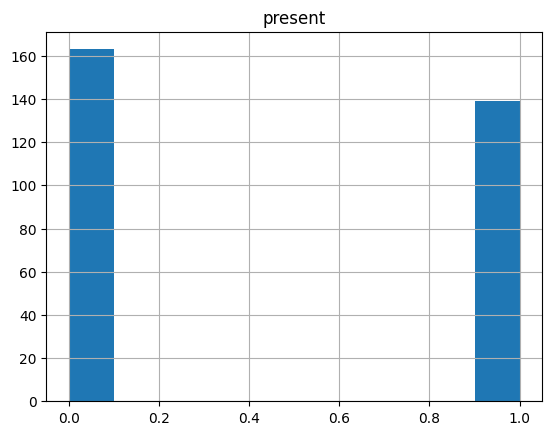

In [9]:
heart['present'] = heart['present'].map(lambda x: 0 if x == 0 else 1)
heart.hist('present')

There's almost an equal number of cases and non-cases in the dataset.

In [10]:

# Checking potential predictors
# heart.groupby("present").mean()
heart.groupby("present").agg(
    {
        "age": "mean",
        "sex": "mean",
        "cp": "mean",
        "trestbps": "mean",
        "chol": "mean",
        "fbs": "mean",
        "restecg": "mean",
        "thalach": "mean",
        "exang": "mean",
        "oldpeak": "mean",
        "slope": "mean",
        "ca": "mean",
        "thal": "mean"
    }
)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
present,,,,,,,,,,,,,
0,52.521472,0.558282,2.803681,129.153374,242.699387,0.134969,0.828221,158.429448,0.141104,0.576074,1.398773,0.251534,3.754601
1,56.625899,0.820144,3.589928,134.568345,251.474820,0.158273,1.172662,139.258993,0.546763,1.574101,1.827338,1.122302,5.791367


Some columns have a small, but noticeable difference when stratified by predictors. Based on the differences and some knowledge about heart disease, these seem like good candidates for predictors:

* age
* thalach (maximum heart rate achieved)
* restecg (resting ECG)
* ca (number of vessels colored by fluoroscopy)

## Dividing The Data

We'll use a 70-30 split of the dataset for the training and test sets.

In [11]:
X = heart[["age", "thalach", "restecg", "ca"]]
y = heart["present"]

# 70% for training set, 30% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [12]:
# Checking for separation in the datasets
print("Y_train: ", sum(y_train == 0))
print("Y_train: ", sum(y_train == 1))
print("Y_test: ", sum(y_test == 0))
print("Y_test: ", sum(y_test == 1))

Y_train:  115
Y_train:  96
Y_test:  48
Y_test:  43


We confirm above that there are both cases and non-cases in both the training and test sets

## Build The Model

In [13]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [14]:
# Checking the various metrics for the model
acc = model.score(X_train, y_train)

predictions = model.predict(X_train)
tp = sum((predictions == 1) & (y_train == 1))
fp = sum((predictions == 1) & (y_train == 0))
tn = sum((predictions == 0) & (y_train == 0))
fn = sum((predictions == 0) & (y_train == 1))
sens = tp / (tp + fn)
spec = tn / (tn + fp)

print("Training Accuracy: ", acc)
print("Training Sensitivity: ", sens)
print("Training Specificity: ", spec)

Training Accuracy:  0.7488151658767772
Training Sensitivity:  0.65625
Training Specificity:  0.8260869565217391


Overall the training accuracy was about 74%, the sensitivity was 65%, and the specificity was 86%. Based on these metrics, the model seems to perform better for non-cases.

## Interpreting The Model Coefficients

In [15]:
coefs = ["age", "thalach", "restecg", "ca"]

# Checking in terms of log-odds
for coef, val  in zip(coefs, model.coef_[0]):
    print(coef, ":", round(val, 2))

age : -0.01
thalach : -0.04
restecg : 0.16
ca : 0.88


In [16]:
# Checking in terms of odds
for coef, val  in zip(coefs, model.coef_[0]):
    print(coef, ":", round(np.exp(val), 2))

age : 0.99
thalach : 0.96
restecg : 1.18
ca : 2.42


* Higher age and maximum heart rate (thalach) is associated with lower odds of heart disease holding the other predictors constant, but both of these odds ratios are close to 1.
* Resting ECG and the number of colored vessels are associated with higher odds of heart disease holding the other predictors constant. These increases seem to be moderate and high, respectively (a 47% increase and 142% increase).

## Final Model Evaluation

In [17]:
# Checking the various metrics for the model (test set)
acc = model.score(X_test, y_test)

predictions = model.predict(X_test)
tp = sum((predictions == 1) & (y_test == 1))
fp = sum((predictions == 1) & (y_test == 0))
tn = sum((predictions == 0) & (y_test == 0))
fn = sum((predictions == 0) & (y_test == 1))
sens = tp / (tp + fn)
spec = tn / (tn + fp)

print("Test Accuracy: ", acc)
print("Test Sensitivity: ", sens)
print("Test Specificity: ", spec)

Test Accuracy:  0.7912087912087912
Test Sensitivity:  0.7674418604651163
Test Specificity:  0.8125


## Drawing Conclusions

Test accuracy was 79%, sensitivity was 76%, and specificity was 81%. Compared to the training set, the accuracy didn't change much, while the model fared better with cases and worse with non-cases. This is potentially useful since this application is health-based. We might be more interested in being better at identifying cases than non-cases.